In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


Loaded 5270 images
Dataset type test label type: species


Loaded 43520 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 0qzdskm4


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-0qzdskm4:best, 314.55MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.6


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_ftr = []
trn_emb = []
trn_lgt = []
trn_tgt = []

val_inp = []
val_ftr = []
val_emb = []
val_lgt = []
val_tgt = []

ind_inp = []
ind_ftr = []
ind_emb = []
ind_lgt = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_ftr = []
    ood_emb = []
    ood_lgt = []
    ood_tgt = []

rnd_inp = []
rnd_ftr = []
rnd_emb = []
rnd_lgt = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_ftr.extend(ftr.detach().cpu().numpy())
    trn_emb.extend(emb.detach().cpu().numpy())
    trn_lgt.extend(lgt.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_ftr.extend(ftr.detach().cpu().numpy())
    val_emb.extend(emb.detach().cpu().numpy())
    val_lgt.extend(lgt.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_ftr.extend(ftr.detach().cpu().numpy())
    ind_emb.extend(emb.detach().cpu().numpy())
    ind_lgt.extend(lgt.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_ftr.extend(ftr.detach().cpu().numpy())
        ood_emb.extend(emb.detach().cpu().numpy())
        ood_lgt.extend(lgt.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_ftr.extend(ftr.detach().cpu().numpy())
    rnd_emb.extend(emb.detach().cpu().numpy())
    rnd_lgt.extend(lgt.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                                                                                                      | 0/659 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                             | 1/659 [00:00<06:37,  1.66it/s]

  2%|██▋                                                                                                                                                                          | 10/659 [00:00<00:35, 18.34it/s]

  3%|████▉                                                                                                                                                                        | 19/659 [00:00<00:19, 33.46it/s]

  4%|███████▌                                                                                                                                                                     | 29/659 [00:00<00:13, 48.08it/s]

  6%|██████████▏                                                                                                                                                                  | 39/659 [00:01<00:10, 60.41it/s]

  7%|████████████▊                                                                                                                                                                | 49/659 [00:01<00:08, 70.40it/s]

  9%|███████████████▍                                                                                                                                                             | 59/659 [00:01<00:07, 78.17it/s]

 10%|██████████████████                                                                                                                                                           | 69/659 [00:01<00:07, 83.66it/s]

 12%|████████████████████▋                                                                                                                                                        | 79/659 [00:01<00:06, 87.34it/s]

 14%|███████████████████████▎                                                                                                                                                     | 89/659 [00:01<00:06, 90.14it/s]

 15%|█████████████████████████▉                                                                                                                                                   | 99/659 [00:01<00:06, 92.08it/s]

 17%|████████████████████████████▍                                                                                                                                               | 109/659 [00:01<00:05, 93.68it/s]

 18%|███████████████████████████████                                                                                                                                             | 119/659 [00:01<00:05, 94.20it/s]

 20%|█████████████████████████████████▋                                                                                                                                          | 129/659 [00:01<00:05, 95.12it/s]

 21%|████████████████████████████████████▎                                                                                                                                       | 139/659 [00:02<00:05, 95.54it/s]

 23%|██████████████████████████████████████▉                                                                                                                                     | 149/659 [00:02<00:05, 96.17it/s]

 24%|█████████████████████████████████████████▍                                                                                                                                  | 159/659 [00:02<00:05, 96.13it/s]

 26%|████████████████████████████████████████████                                                                                                                                | 169/659 [00:02<00:05, 96.47it/s]

 27%|██████████████████████████████████████████████▋                                                                                                                             | 179/659 [00:02<00:04, 96.58it/s]

 29%|█████████████████████████████████████████████████▎                                                                                                                          | 189/659 [00:02<00:04, 97.01it/s]

 30%|███████████████████████████████████████████████████▉                                                                                                                        | 199/659 [00:02<00:04, 96.90it/s]

 32%|██████████████████████████████████████████████████████▌                                                                                                                     | 209/659 [00:02<00:04, 97.11it/s]

 33%|█████████████████████████████████████████████████████████▏                                                                                                                  | 219/659 [00:02<00:04, 97.09it/s]

 35%|███████████████████████████████████████████████████████████▊                                                                                                                | 229/659 [00:02<00:04, 96.68it/s]

 36%|██████████████████████████████████████████████████████████████▍                                                                                                             | 239/659 [00:03<00:04, 95.86it/s]

 38%|████████████████████████████████████████████████████████████████▉                                                                                                           | 249/659 [00:03<00:04, 95.75it/s]

 39%|███████████████████████████████████████████████████████████████████▌                                                                                                        | 259/659 [00:03<00:04, 92.81it/s]

 41%|██████████████████████████████████████████████████████████████████████▏                                                                                                     | 269/659 [00:03<00:04, 91.21it/s]

 42%|████████████████████████████████████████████████████████████████████████▊                                                                                                   | 279/659 [00:03<00:04, 90.03it/s]

 44%|███████████████████████████████████████████████████████████████████████████▍                                                                                                | 289/659 [00:03<00:04, 89.16it/s]

 45%|█████████████████████████████████████████████████████████████████████████████▊                                                                                              | 298/659 [00:03<00:04, 88.64it/s]

 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 307/659 [00:03<00:03, 88.26it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 317/659 [00:03<00:03, 89.09it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 327/659 [00:04<00:03, 92.16it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 338/659 [00:04<00:03, 94.65it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 349/659 [00:04<00:03, 96.41it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 359/659 [00:04<00:03, 97.41it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 369/659 [00:04<00:02, 98.13it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 379/659 [00:04<00:02, 97.86it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 389/659 [00:04<00:02, 97.86it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 399/659 [00:04<00:02, 97.85it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 409/659 [00:04<00:02, 97.75it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 419/659 [00:04<00:02, 97.67it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 429/659 [00:05<00:02, 97.63it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 439/659 [00:05<00:02, 97.77it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 449/659 [00:05<00:02, 98.38it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 459/659 [00:05<00:02, 97.37it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 470/659 [00:05<00:01, 98.17it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 481/659 [00:05<00:01, 98.91it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 492/659 [00:05<00:01, 99.27it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 502/659 [00:05<00:01, 99.38it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 513/659 [00:05<00:01, 99.66it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 523/659 [00:06<00:01, 99.51it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 533/659 [00:06<00:01, 99.60it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 544/659 [00:06<00:01, 99.78it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 554/659 [00:06<00:01, 99.04it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 564/659 [00:06<00:00, 98.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 574/659 [00:06<00:00, 98.27it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 584/659 [00:06<00:00, 98.03it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 594/659 [00:06<00:00, 97.90it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 604/659 [00:06<00:00, 97.76it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 614/659 [00:06<00:00, 97.79it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 624/659 [00:07<00:00, 97.48it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 634/659 [00:07<00:00, 97.32it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 644/659 [00:07<00:00, 97.33it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 654/659 [00:07<00:00, 94.74it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 659/659 [00:07<00:00, 87.33it/s]

train - OK


  0%|                                                                                                                                                                                       | 0/83 [00:00<?, ?it/s]

  1%|██                                                                                                                                                                             | 1/83 [00:00<00:17,  4.56it/s]

 13%|███████████████████████                                                                                                                                                       | 11/83 [00:00<00:01, 40.76it/s]

 25%|████████████████████████████████████████████                                                                                                                                  | 21/83 [00:00<00:01, 61.16it/s]

 37%|████████████████████████████████████████████████████████████████▉                                                                                                             | 31/83 [00:00<00:00, 73.35it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 41/83 [00:00<00:00, 80.22it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 51/83 [00:00<00:00, 84.79it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 61/83 [00:00<00:00, 88.19it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 71/83 [00:00<00:00, 90.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 81/83 [00:01<00:00, 92.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 69.07it/s]

val - OK


  0%|                                                                                                                                                                                       | 0/83 [00:00<?, ?it/s]

  1%|██                                                                                                                                                                             | 1/83 [00:00<00:19,  4.27it/s]

 12%|████████████████████▉                                                                                                                                                         | 10/83 [00:00<00:02, 35.86it/s]

 23%|███████████████████████████████████████▊                                                                                                                                      | 19/83 [00:00<00:01, 53.74it/s]

 34%|██████████████████████████████████████████████████████████▋                                                                                                                   | 28/83 [00:00<00:00, 65.29it/s]

 45%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                | 37/83 [00:00<00:00, 72.31it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 46/83 [00:00<00:00, 77.41it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 55/83 [00:00<00:00, 80.76it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 64/83 [00:00<00:00, 83.21it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 74/83 [00:01<00:00, 86.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 75.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 64.47it/s]

test InD - OK


  0%|                                                                                                                                                                                      | 0/680 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                             | 1/680 [00:00<02:55,  3.87it/s]

  1%|██▌                                                                                                                                                                          | 10/680 [00:00<00:19, 34.06it/s]

  3%|████▊                                                                                                                                                                        | 19/680 [00:00<00:12, 52.27it/s]

  4%|███████▍                                                                                                                                                                     | 29/680 [00:00<00:09, 65.96it/s]

  6%|█████████▉                                                                                                                                                                   | 39/680 [00:00<00:08, 75.37it/s]

  7%|████████████▍                                                                                                                                                                | 49/680 [00:00<00:07, 82.17it/s]

  9%|███████████████                                                                                                                                                              | 59/680 [00:00<00:07, 87.06it/s]

 10%|█████████████████▌                                                                                                                                                           | 69/680 [00:00<00:06, 89.82it/s]

 12%|████████████████████                                                                                                                                                         | 79/680 [00:01<00:06, 92.26it/s]

 13%|██████████████████████▋                                                                                                                                                      | 89/680 [00:01<00:06, 93.84it/s]

 15%|█████████████████████████▏                                                                                                                                                   | 99/680 [00:01<00:06, 95.31it/s]

 16%|███████████████████████████▌                                                                                                                                                | 109/680 [00:01<00:05, 96.39it/s]

 18%|██████████████████████████████                                                                                                                                              | 119/680 [00:01<00:05, 96.62it/s]

 19%|████████████████████████████████▋                                                                                                                                           | 129/680 [00:01<00:05, 96.09it/s]

 20%|███████████████████████████████████▏                                                                                                                                        | 139/680 [00:01<00:05, 95.72it/s]

 22%|█████████████████████████████████████▋                                                                                                                                      | 149/680 [00:01<00:05, 95.55it/s]

 23%|████████████████████████████████████████▏                                                                                                                                   | 159/680 [00:01<00:05, 95.33it/s]

 25%|██████████████████████████████████████████▋                                                                                                                                 | 169/680 [00:02<00:05, 94.80it/s]

 26%|█████████████████████████████████████████████▎                                                                                                                              | 179/680 [00:02<00:05, 94.72it/s]

 28%|███████████████████████████████████████████████▊                                                                                                                            | 189/680 [00:02<00:05, 94.89it/s]

 29%|██████████████████████████████████████████████████▎                                                                                                                         | 199/680 [00:02<00:05, 94.83it/s]

 31%|████████████████████████████████████████████████████▊                                                                                                                       | 209/680 [00:02<00:04, 94.95it/s]

 32%|███████████████████████████████████████████████████████▍                                                                                                                    | 219/680 [00:02<00:04, 95.04it/s]

 34%|█████████████████████████████████████████████████████████▉                                                                                                                  | 229/680 [00:02<00:04, 94.85it/s]

 35%|████████████████████████████████████████████████████████████▍                                                                                                               | 239/680 [00:02<00:04, 95.12it/s]

 37%|██████████████████████████████████████████████████████████████▉                                                                                                             | 249/680 [00:02<00:04, 95.09it/s]

 38%|█████████████████████████████████████████████████████████████████▌                                                                                                          | 259/680 [00:02<00:04, 95.16it/s]

 40%|████████████████████████████████████████████████████████████████████                                                                                                        | 269/680 [00:03<00:04, 95.22it/s]

 41%|██████████████████████████████████████████████████████████████████████▌                                                                                                     | 279/680 [00:03<00:04, 95.25it/s]

 42%|█████████████████████████████████████████████████████████████████████████                                                                                                   | 289/680 [00:03<00:04, 94.97it/s]

 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                | 299/680 [00:03<00:04, 95.22it/s]

 45%|██████████████████████████████████████████████████████████████████████████████▏                                                                                             | 309/680 [00:03<00:03, 95.25it/s]

 47%|████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 319/680 [00:03<00:03, 95.24it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 329/680 [00:03<00:03, 95.52it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 339/680 [00:03<00:03, 96.21it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 349/680 [00:03<00:03, 96.37it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 359/680 [00:04<00:03, 96.40it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 369/680 [00:04<00:03, 96.47it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 379/680 [00:04<00:03, 96.74it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 389/680 [00:04<00:03, 96.89it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 399/680 [00:04<00:02, 96.69it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 409/680 [00:04<00:02, 95.29it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 419/680 [00:04<00:02, 94.17it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 429/680 [00:04<00:02, 93.43it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 439/680 [00:04<00:02, 92.96it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 449/680 [00:04<00:02, 92.72it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 459/680 [00:05<00:02, 92.44it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 469/680 [00:05<00:02, 92.26it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 479/680 [00:05<00:02, 92.24it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 489/680 [00:05<00:02, 92.19it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 499/680 [00:05<00:01, 92.12it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 509/680 [00:05<00:01, 92.09it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 519/680 [00:05<00:01, 91.95it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 529/680 [00:05<00:01, 91.61it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 539/680 [00:05<00:01, 91.78it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 549/680 [00:06<00:01, 91.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 559/680 [00:06<00:01, 91.81it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 569/680 [00:06<00:01, 91.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 579/680 [00:06<00:01, 91.89it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 589/680 [00:06<00:00, 91.97it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 599/680 [00:06<00:00, 91.68it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 609/680 [00:06<00:00, 91.84it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 619/680 [00:06<00:00, 91.96it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 629/680 [00:06<00:00, 92.10it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 639/680 [00:07<00:00, 92.12it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 649/680 [00:07<00:00, 91.79it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 659/680 [00:07<00:00, 91.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 669/680 [00:07<00:00, 92.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 679/680 [00:07<00:00, 92.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 680/680 [00:07<00:00, 90.06it/s]

test OoD - OK


  0%|                                                                                                                                                                                      | 0/100 [00:00<?, ?it/s]

 12%|████████████████████▋                                                                                                                                                       | 12/100 [00:00<00:00, 110.54it/s]

 24%|█████████████████████████████████████████▎                                                                                                                                  | 24/100 [00:00<00:00, 110.85it/s]

 36%|█████████████████████████████████████████████████████████████▉                                                                                                              | 36/100 [00:00<00:00, 110.99it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 48/100 [00:00<00:00, 110.24it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 60/100 [00:00<00:00, 110.61it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 72/100 [00:00<00:00, 110.83it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 84/100 [00:00<00:00, 111.01it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 96/100 [00:00<00:00, 111.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 110.89it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(42153, 3, 64, 64) (42153, 2048) (42153, 512) (42153, 2) (42153,)
(5269, 3, 64, 64) (5269, 2048) (5269, 512) (5269, 2) (5269,)
(5270, 3, 64, 64) (5270, 2048) (5270, 512) (5270, 2) (5270,)
(43520, 3, 64, 64) (43520, 2048) (43520, 512) (43520, 2) (43520,)
(6400, 3, 64, 64) (6400, 2048) (6400, 512) (6400, 2)


In [12]:
from tsnecuda import TSNE

n = ind_ftr.shape[0]

if ood_str:
    all_ftr = np.concatenate([ind_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([ind_lgt, ood_lgt], axis=0)
else:
    all_ftr = ind_ftr
    all_lgt = ind_lgt

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5270, 2) (43520, 2)
(5270, 2) (43520, 2)


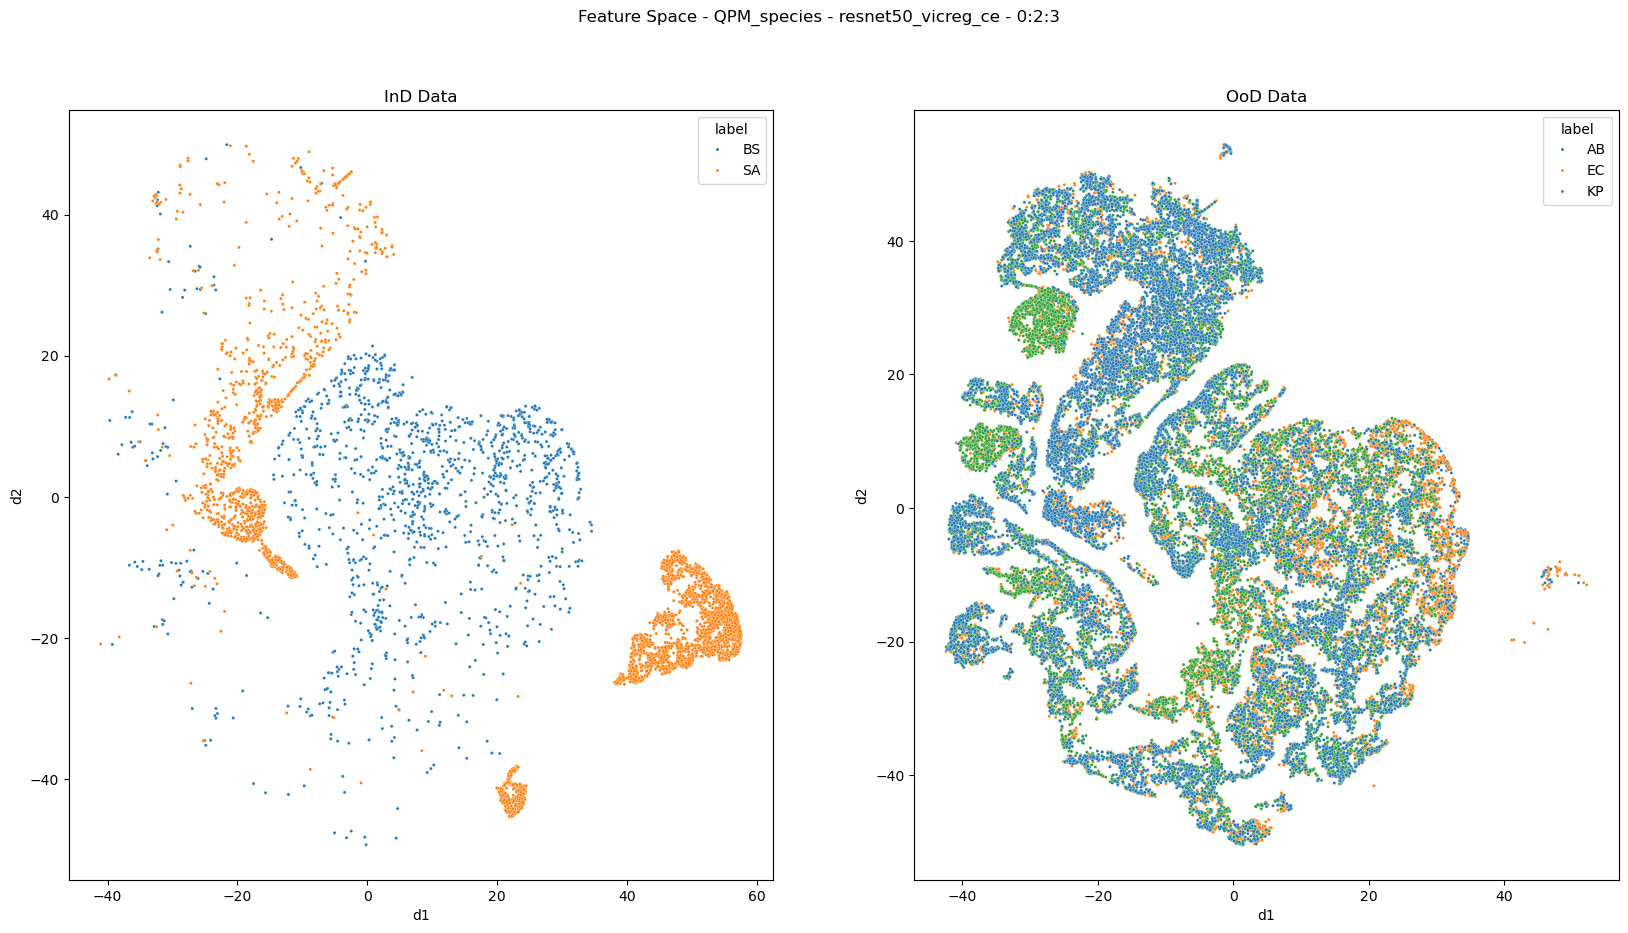

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

ftr_data = pd.DataFrame()
d1, d2 = ind_ftr2d.T
ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

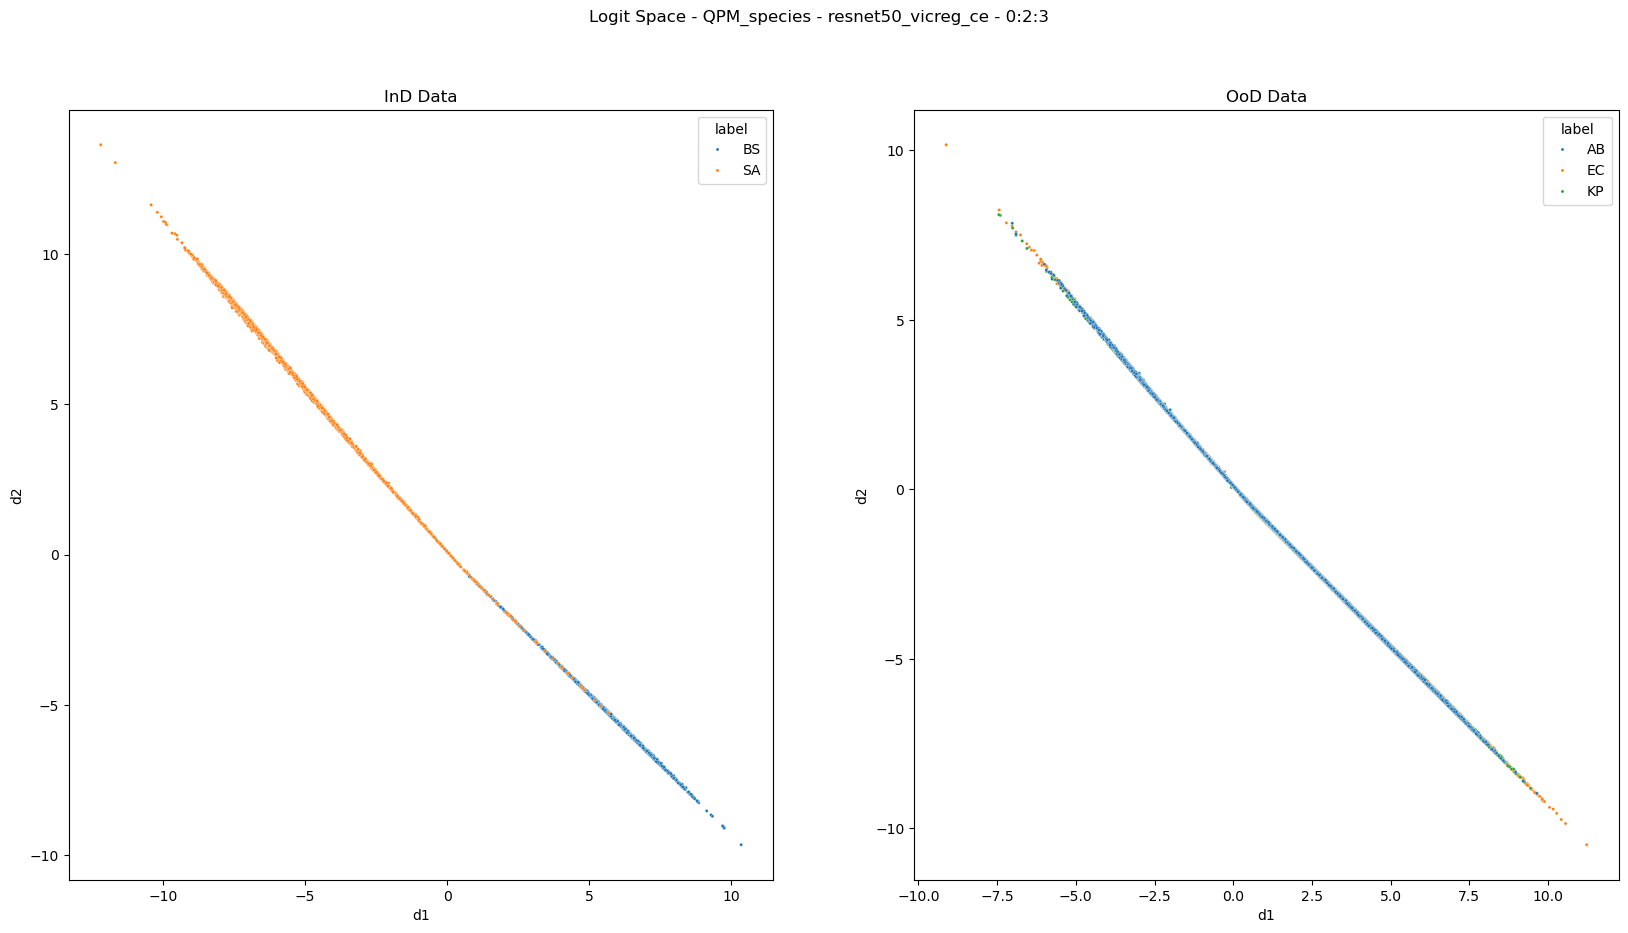

In [14]:
lgt_data = pd.DataFrame()
d1, d2 = ind_lgt2d.T
lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████████████                                                                                                                                    | 1/4 [00:06<00:19,  6.61s/it]

 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2/4 [00:13<00:13,  6.60s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3/4 [00:19<00:06,  6.62s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.65s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.63s/it]

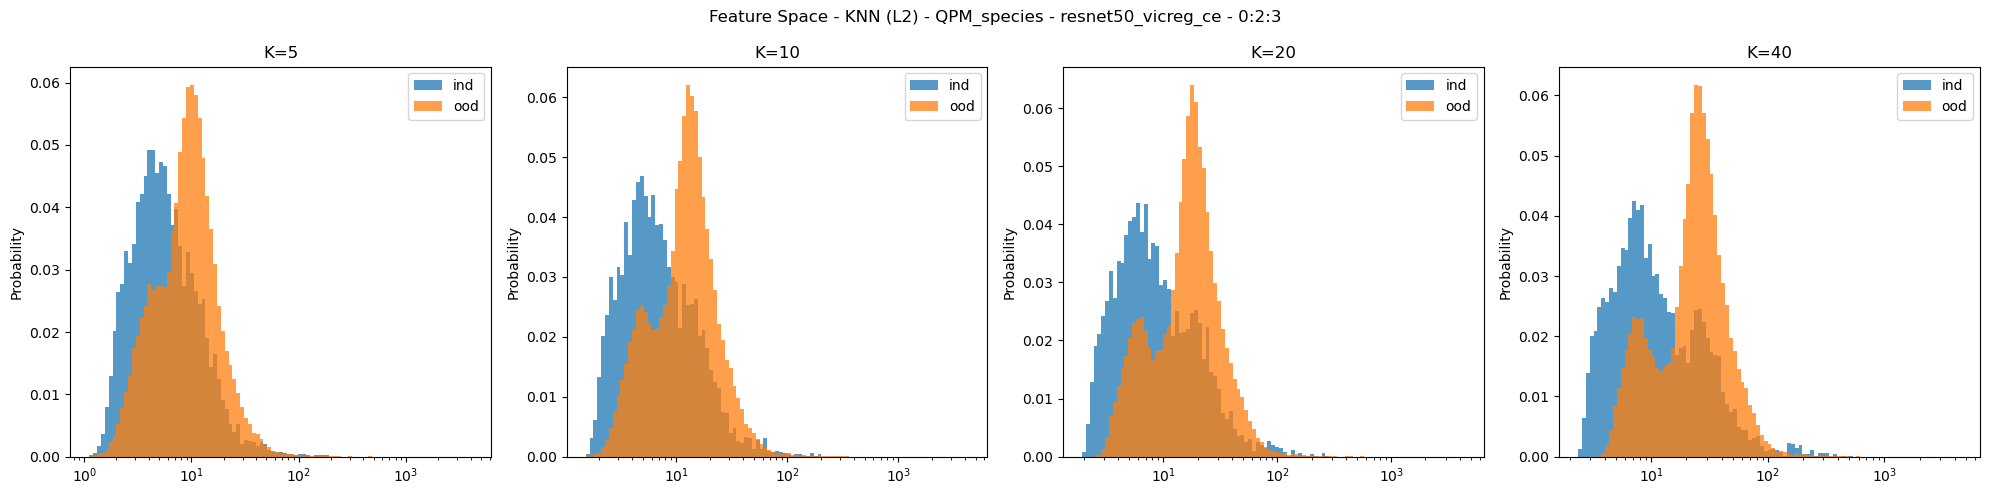

In [15]:
import faiss

index_ftr = faiss.IndexFlatL2(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████████████                                                                                                                                    | 1/4 [00:06<00:18,  6.03s/it]

 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2/4 [00:12<00:12,  6.04s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3/4 [00:18<00:06,  6.21s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  6.28s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  6.22s/it]

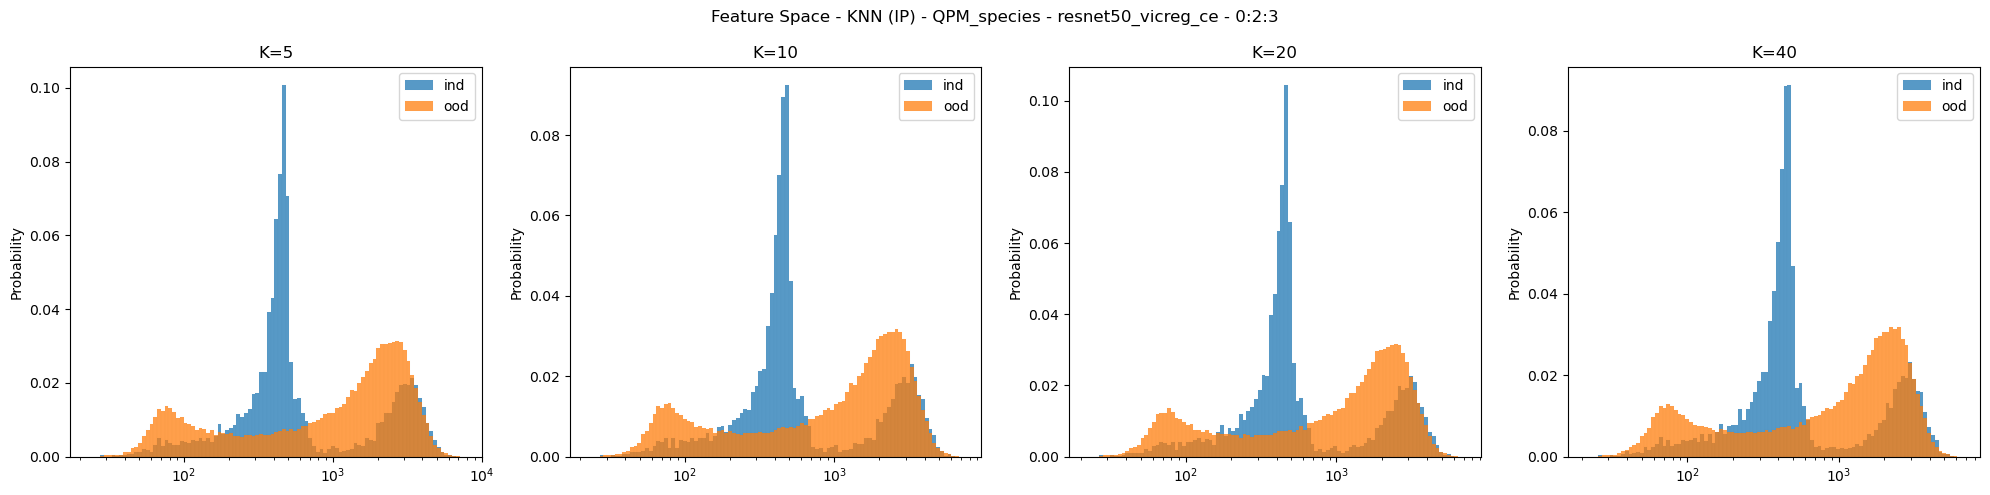

In [16]:
import faiss

index_ftr = faiss.IndexFlatIP(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████████████                                                                                                                                    | 1/4 [00:06<00:18,  6.01s/it]

 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2/4 [00:12<00:12,  6.04s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3/4 [00:18<00:06,  6.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.35s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.25s/it]

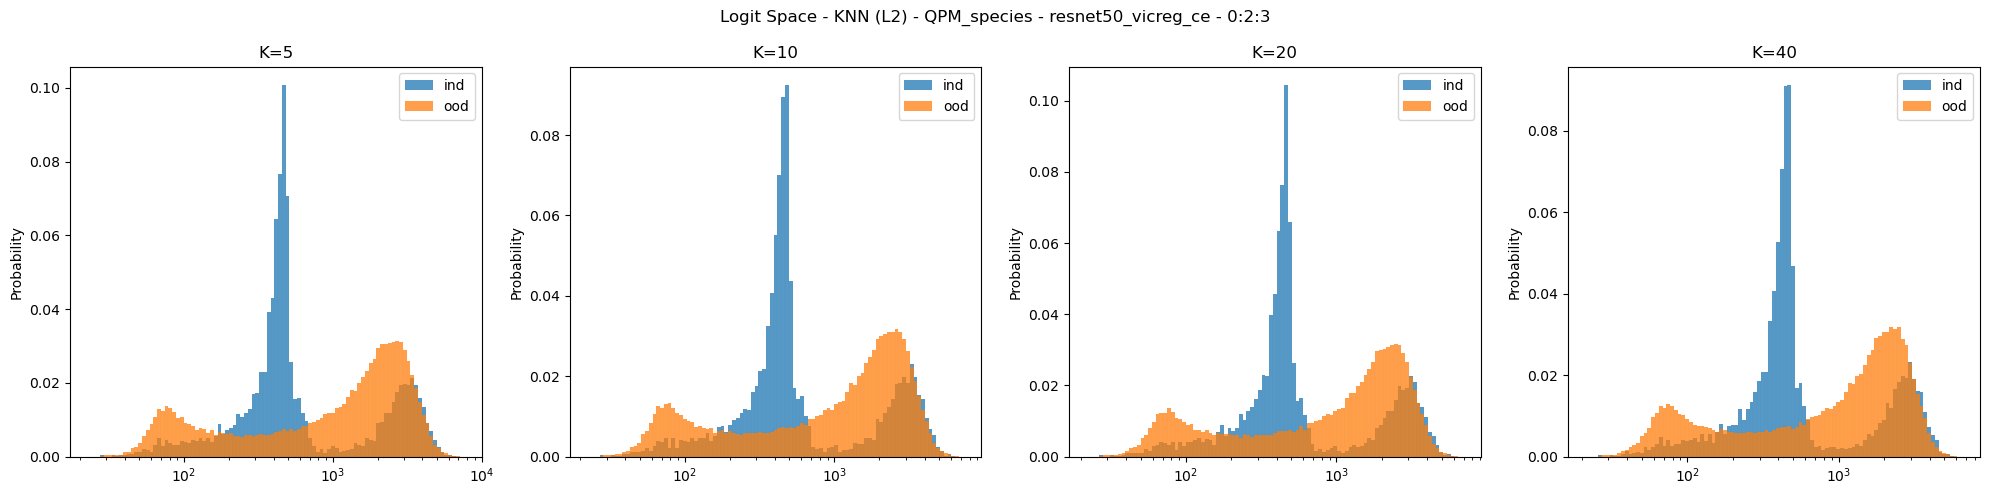

In [17]:
import faiss

index_lgt = faiss.IndexFlatL2(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████████████                                                                                                                                    | 1/4 [00:06<00:18,  6.28s/it]

 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2/4 [00:12<00:13,  6.53s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3/4 [00:19<00:06,  6.46s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.43s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.44s/it]

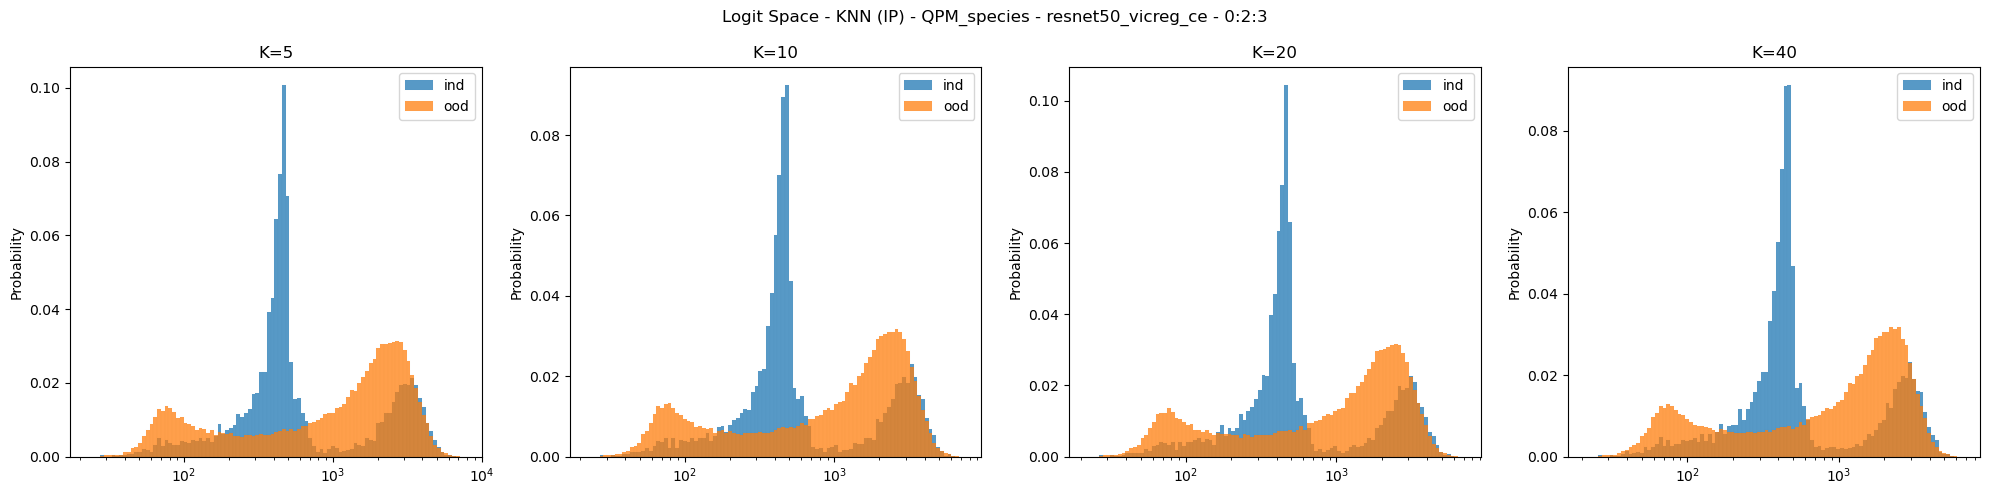

In [18]:
import faiss

index_lgt = faiss.IndexFlatIP(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

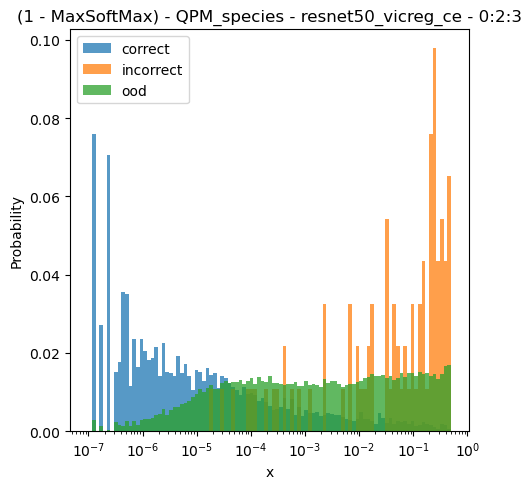

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()